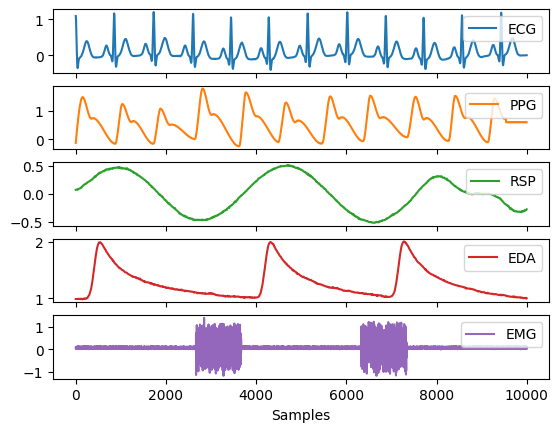

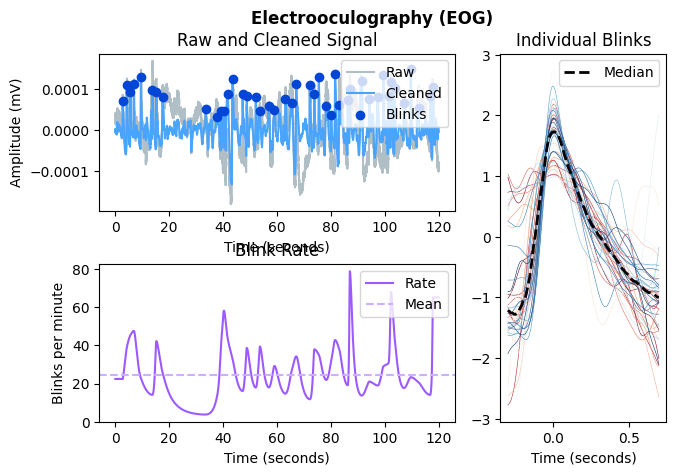

In [3]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import mne


# Generate synthetic signals
ecg = nk.ecg_simulate(duration=10, heart_rate=70)
ppg = nk.ppg_simulate(duration=10, heart_rate=70)
rsp = nk.rsp_simulate(duration=10, respiratory_rate=15)
eda = nk.eda_simulate(duration=10, scr_number=3)
emg = nk.emg_simulate(duration=10, burst_number=2)

# Visualise biosignals
data = pd.DataFrame({"ECG": ecg,
                     "PPG": ppg,
                     "RSP": rsp,
                     "EDA": eda,
                     "EMG": emg})
nk.signal_plot(data, subplots=True)





# Import EOG data
eog_signal = nk.data("eog_100hz")

# Process it
signals, info = nk.eog_process(eog_signal, sampling_rate=100)

# Plot
nk.eog_plot(signals, info)